In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [2]:
sns.set_theme(style='whitegrid')

### The first part of the notebook shows how to create figures for mean, quantiles and tail distribution using outputs generated with truncated workloads.

In [3]:
input_location = ''
schedule_names = ['fcfs', 'fcfs-easy', 'filler', 'fcfs-bb', 'sjf-bb', 'plan-1', 'plan-2', 'plan-3']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_jobs.csv'):
        jobs_files.append(file)

jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(jobs_files)

['../output/fcfs-bb_jobs.csv', '../output/fcfs-easy_jobs.csv', '../output/fcfs_jobs.csv', '../output/filler_jobs.csv', '../output/plan-1_jobs.csv', '../output/plan-2_jobs.csv', '../output/plan-3_jobs.csv', '../output/sjf-bb_jobs.csv']


In [5]:
jobsets = {}
for file in jobs_files:
    schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

fcfs-bb
fcfs-easy
fcfs
filler
plan-1
plan-2
plan-3
sjf-bb


In [6]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [7]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [8]:
def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [9]:
metrics_df = create_all_metrics_df()
metrics_df.waiting_time /= 60 * 60

In [10]:
waiting_times = create_metric_df('waiting_time')

Text(0.5, 0, '')

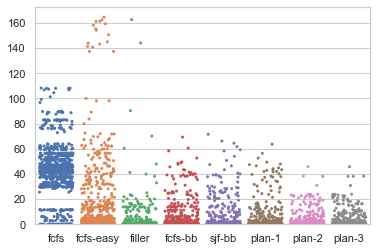

In [11]:
# Waiting time tail distribution
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']] for schedule in schedule_names])
fig, ax = plt.subplots()
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylabel('')
ax.set_xlabel('')

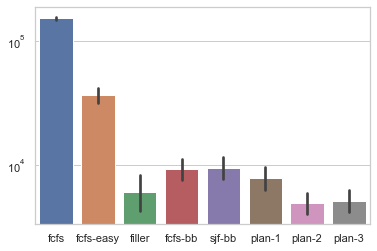

In [12]:
# Mean waiting time
fig, ax = plt.subplots()
sns.barplot(data=waiting_times, ax=ax)
ax.set_yscale('log')

(1, 461477.1889222955)

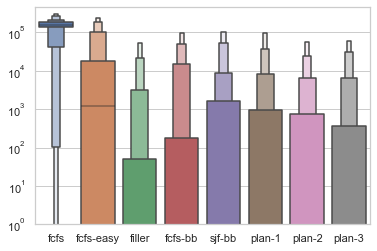

In [13]:
# Waiting time quantiles
fig, ax = plt.subplots()
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)

Text(0.5, 0, '')

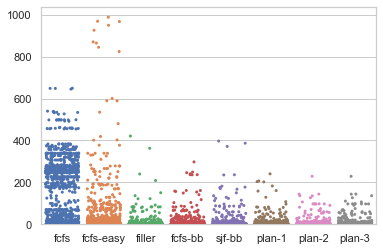

In [14]:
# Bounded slowdown tail dist.
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']] for schedule in schedule_names])
fig, ax = plt.subplots()
sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 0, '')

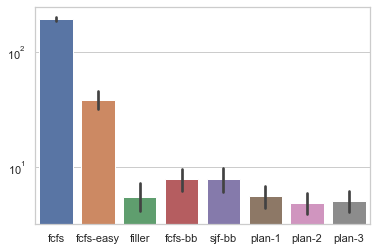

In [15]:
# Mean bounded slowdown
fig, ax = plt.subplots()
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_yscale('log')
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 0, '')

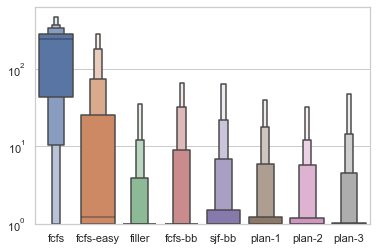

In [16]:
# Bounded slowdown quantiles
fig, ax = plt.subplots()
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)
ax.set_ylabel('')
ax.set_xlabel('')

### The following part of the notebook shows how to reproduce Figures 5-10 on the full workloads.

In [16]:
input_location = 'KTH-full/io-aware'
files_prefix = ''
schedule_names = ['fcfs', 'no-future-1', 'filler', 'backfill-1', 'backfill-sjf-1', 'plan-opt-sum-0', 'plan-opt-square-0', 'plan-opt-cube-0']
new_names = ['fcfs', 'fcfs-easy', 'filler', 'fcfs-bb', 'sjf-bb', 'plan-1', 'plan-2', 'plan-3']

In [17]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_jobs.csv'):
        jobs_files.append(file)

jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(jobs_files)

['../output/KTH-full/io-aware/backfill-1_jobs.csv', '../output/KTH-full/io-aware/backfill-sjf-1_jobs.csv', '../output/KTH-full/io-aware/fcfs_jobs.csv', '../output/KTH-full/io-aware/filler_jobs.csv', '../output/KTH-full/io-aware/no-future-1_jobs.csv', '../output/KTH-full/io-aware/plan-opt-cube-0_jobs.csv', '../output/KTH-full/io-aware/plan-opt-square-0_jobs.csv', '../output/KTH-full/io-aware/plan-opt-sum-0_jobs.csv']


In [18]:
jobsets = {}
for file in jobs_files:
    schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

backfill-1
backfill-sjf-1
fcfs
filler
no-future-1
plan-opt-cube-0
plan-opt-square-0
plan-opt-sum-0


In [19]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [34]:
# rename schedules
new_jobsets = {}
for old_name, new_name in zip(schedule_names, new_names):
    new_jobsets[new_name] = jobsets[old_name]
schedule_names = new_names
jobsets = new_jobsets

In [35]:
metrics_df = create_all_metrics_df()
metrics_df.waiting_time /= 60 * 60

In [47]:
waiting_times = create_metric_df('waiting_time')
waiting_times /= 60 * 60

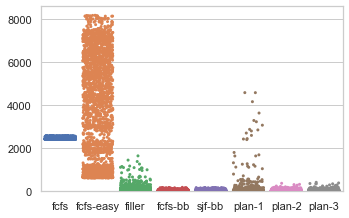

In [48]:
# Fig. 9. Waiting time tail distribution [h].
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=3000, columns='waiting_time') for schedule in schedule_names])
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../images/waiting-time_dist.pdf', bbox_inches='tight')

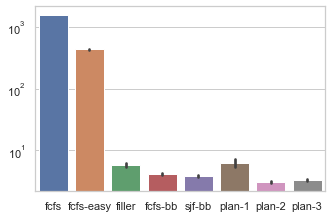

In [49]:
# Fig. 5. Mean waiting time [hours].
fig, ax = plt.subplots(figsize=(5.2,3.4))
sns.barplot(data=waiting_times, ax=ax)
ax.set_yscale('log')
fig.savefig('../images/waiting-time_mean.pdf', bbox_inches='tight')

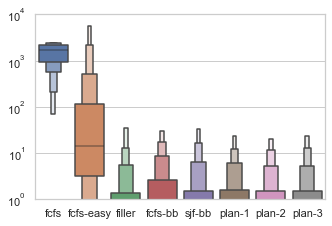

In [50]:
# Fig. 7. Waiting time quantiles [h].
fig, ax = plt.subplots(figsize=(5.2,3.4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)
ax.set_ylim(top=10**4)
fig.savefig('../images/waiting-time_boxen.pdf', bbox_inches='tight')

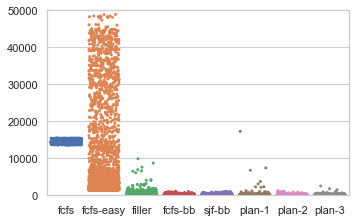

In [46]:
# Fig. 10. Bounded slowdown tail dist.
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']].nlargest(n=3000, columns='bounded_slowdown') for schedule in schedule_names])
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=50000)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../images/bounded-slowdown_dist.pdf', bbox_inches='tight')

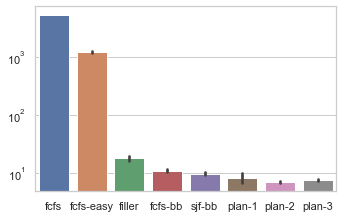

In [51]:
# Fig. 6. Mean bounded slowdown.
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_yscale('log')
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../images/bounded-slowdown_mean.pdf', bbox_inches='tight')

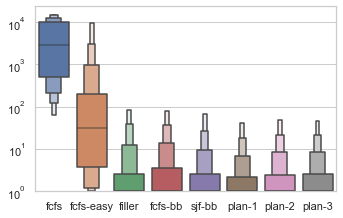

In [52]:
# Fig. 8. Bounded slowdown quantiles.
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../images/bounded-slowdown_boxen.pdf', bbox_inches='tight')

### This part presents how to create Figures 11. and 12. using split workloads.

In [76]:
# input_location = 'KTH-split/alloc-only'
input_location = 'KTH-split/io-aware'
num_parts = 16
schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'plan-opt-sum-0', 'plan-opt-square-0', 'plan-opt-cube-0']
new_names = ['filler', 'fcfs-bb', 'sjf-bb', 'plan-1', 'plan-2', 'plan-3']

In [77]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_jobs.csv'):
        jobs_files.append(file)

jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]

In [78]:
jobsets = {schedule: [None] * num_parts for schedule in schedule_names}
for file in jobs_files:
    schedule_name, part, _ = os.path.basename(file).split('_')
    part_index = int(part.split('-')[1])
    if schedule_name in schedule_names:
        jobsets[schedule_name][part_index] = JobSet.from_csv(file)

In [79]:
def transform_jobset_df(df):
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

def create_all_data_df():
    dfs = []
    for schedule in schedule_names:
        for i in range(len(jobsets[schedule])):
            df = jobsets[schedule][i].df
            df = df.assign(schedule=schedule, part=i, bounded_slowdown=bounded_slowdown(df))[['schedule', 'part', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
            df.rename({'stretch': 'slowdown'}, axis=1, inplace=True)
            dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [80]:
for schedule in schedule_names:
    for i in range(len(jobsets[schedule])):
        jobsets[schedule][i].df = transform_jobset_df(jobsets[schedule][i].df)

In [67]:
# rename schedules
new_jobsets = {}
for old_name, new_name in zip(schedule_names, new_names):
    new_jobsets[new_name] = jobsets[old_name]
schedule_names = new_names
jobsets = new_jobsets

In [68]:
all_data = create_all_data_df()
all_data['part'] += 1

In [72]:
aggregated = all_data.groupby(['schedule', 'part']).mean()
normalised = aggregated.copy()
for schedule in schedule_names:
    for i in range(1, num_parts + 1):
        normalised.loc[schedule, i] = aggregated.loc[schedule, i] / aggregated.loc['sjf-bb', i]
mean_normalised = normalised.reset_index(level=[0,1])

In [73]:
palette = sns.color_palette("deep")
palette.pop(0); palette.pop(0); palette.pop(2)
palette

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

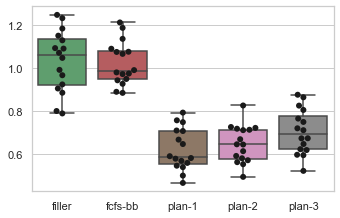

In [74]:
# Fig. 11. Normalised mean waiting time distribution over 16 workload parts.
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.boxplot(data=mean_normalised, x='schedule', y='waiting_time', fliersize=False, order=['filler', 'fcfs-bb', 'plan-1', 'plan-2', 'plan-3'], palette=palette)
sns.swarmplot(data=mean_normalised, x='schedule', y='waiting_time', color=".1", size=6, order=['filler', 'fcfs-bb', 'plan-1', 'plan-2', 'plan-3'])
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../images/waiting-time_split.pdf', bbox_inches='tight')

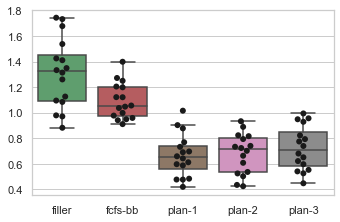

In [75]:
# Fig. 12. Normalised mean bounded slowdown distribution over 16 workload parts.
fig, ax = plt.subplots(figsize=(5.4,3.4))
sns.boxplot(data=mean_normalised, x='schedule', y='bounded_slowdown', fliersize=False, order=['filler', 'fcfs-bb', 'plan-1', 'plan-2', 'plan-3'], palette=palette)
sns.swarmplot(data=mean_normalised, x='schedule', y='bounded_slowdown', color=".1", size=6, order=['filler', 'fcfs-bb', 'plan-1', 'plan-2', 'plan-3'])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(top=1.8)
fig.savefig('../images/bounded-slowdown_split.pdf', bbox_inches='tight')

### The last part is a reproduction of Figure 3. This figure uses data from a simulation in Alloc-Only model, while all other experiments are using IO-Aware model.

In [113]:
input_location = 'KTH-full/alloc-only/no-future-1_jobs.csv'
js = JobSet.from_csv('../output/' + input_location)

In [114]:
df = js.df.sort_values('starting_time')
df = df.head(3500)
df['jobID'] = ''
subjs = JobSet(df)

/Users/jankopanski/master2/Burst-Buffer-Scheduling/tools/lib/python3.8/site-packages/evalys/visu/core.py:102: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig.canvas.set_window_title(wtitle)
/Users/jankopanski/master2/Burst-Buffer-Scheduling/tools/lib/python3.8/site-packages/evalys/visu/core.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


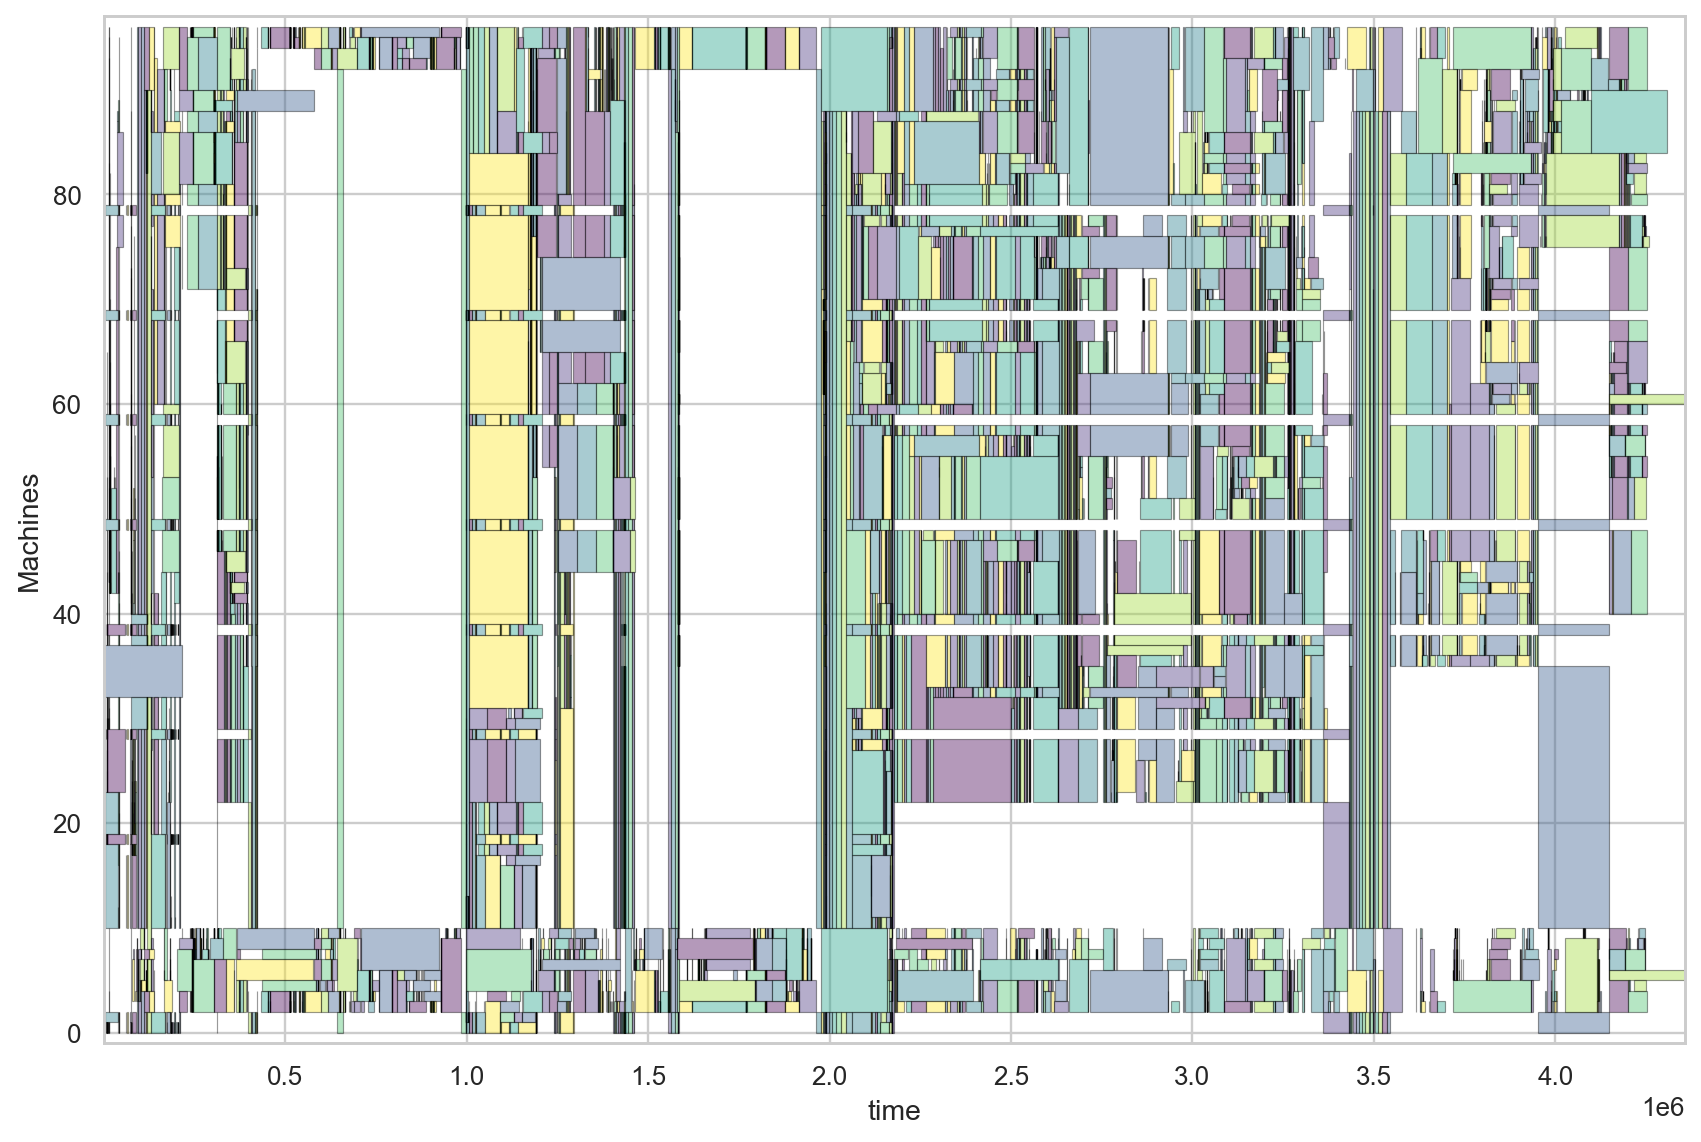

In [115]:
matplotlib.rcParams['figure.figsize'] = 12, 8
matplotlib.rcParams['figure.dpi']= 170
subjs.gantt(title=None)
plt.xlabel('time')
plt.ylabel('Machines')
plt.savefig('../images/reservation_alloc-only_gantt_future_head.pdf', bbox_inches='tight')